In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load Data

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.csv.gz`, `test_history.csv.gz`, `train_history.csv.gz`, and `transactions.csv.gz`.

In [3]:
# This will ask you to give Colab permission to access your Google Drive 
# and enter an authorization code.
# See: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# MODIFY THIS LINE with the path to where you saved the datafiles on your Google drive
# path = '/content/drive/My Drive/Colab Notebooks/RSM8521 - Assignment 3/'

In [3]:
# promos = pd.read_csv(path + '/promos.csv.gz')
promos = pd.read_csv('promos.csv.gz')
promos.head()

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935


In [4]:
# train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
train_history = pd.read_csv('train_history.csv.gz', parse_dates=['promodate'])
train_history.head()

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0


<AxesSubplot:>

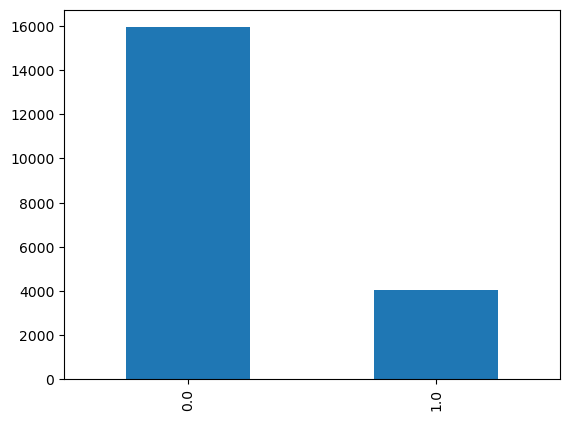

In [6]:
train_history['active'].value_counts().plot(kind='bar')

In [8]:
# test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
test_history = pd.read_csv('test_history.csv.gz', parse_dates=['promodate'])
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [10]:
# transactions = pd.read_csv(path + 'transactions.csv.gz', parse_dates=['date'])
transactions = pd.read_csv('../transactions.csv.gz', parse_dates=['date'])
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19


# Extract Features

## Compute RFM Features

In [11]:
max_date = transactions.date.max()
transactions['last_purchase'] = (max_date - transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
trans_features = transactions.groupby('id').agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

# Compute RFM columns
trans_features['recency'] = trans_features['last_purchase']['min']
trans_features['frequency'] = (trans_features['date']['nunique']
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['monetary'] = trans_features['amt']['sum']

# Select out required features
trans_features = trans_features[['recency', 'frequency', 'monetary']].reset_index()
trans_features.columns = trans_features.columns.get_level_values(0)
trans_features.head()

,id,recency,frequency,monetary
0,32159355,3.0,0.201117,3141.84
1,38085541,4.0,0.146814,2231.17
2,41697872,0.0,0.248619,5006.52
3,54676900,0.0,0.245810,1793.02
4,58631253,0.0,0.251381,4926.40


## Generate train, test and prediction sets

In [12]:
# Generate train/test features
features = train_history.merge(trans_features, on='id', how='left')
features.recency.fillna(365, inplace=True)
features.frequency.fillna(0, inplace=True)
features.monetary.fillna(0, inplace=True)

x_cols = ['recency', 'frequency', 'monetary']
y_col = 'active'

X = features[x_cols]
y = features[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
# Generate prediction features (for blind test)
predict_features = test_history.merge(trans_features, on='id', how='left')
predict_features.recency.fillna(365, inplace=True)
predict_features.frequency.fillna(0, inplace=True)
predict_features.monetary.fillna(0, inplace=True)

X_predict = predict_features[x_cols]
predict_out = predict_features[['id', 'active']].copy()

# Build Model

In [14]:
model = RandomForestClassifier(100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
model.predict_proba(X_test)

array([[0.77, 0.23],
       [0.98, 0.02],
       [0.68, 0.32],
       ...,
       [0.98, 0.02],
       [0.8 , 0.2 ],
       [0.77, 0.23]])

In [13]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

Test Accuracy: 0.78
Test AUC: 0.52


# Generate Prediction

In [14]:
predict_out.head()

,id,active
0,250462324156,NaN
1,61214568335,NaN
2,274776763999,NaN
3,91546215019,NaN
4,220718580189,NaN


In [15]:
predict_out['active'] = model.predict_proba(X_predict)[:, 1]
predict_out.head()

,id,active
0,250462324156,0.03
1,61214568335,0.49
2,274776763999,0.23
3,91546215019,0.06
4,220718580189,0.33


In [16]:
predict_out.to_csv('predict.csv', header=True, index=False)
predict_out.head()

,id,active
0,250462324156,0.03
1,61214568335,0.49
2,274776763999,0.23
3,91546215019,0.06
4,220718580189,0.33


In [17]:
# This will download your prediction files
# from google.colab import files
# files.download('predict.csv')

ModuleNotFoundError: No module named 'google.colab'